<center>
<h1> Credit Risk Analytics <h1>
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the populationmm

#### 1. IMPORTING THE PACKAGES

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from sklearn.metrics import confusion_matrix , classification_report , roc_auc_score , accuracy_score

#### 2. data availablity

In [11]:
bankloans = pd.read_csv(r"C:\Users\Hp\OneDrive\Desktop\Python1\Class 21\Bankloans - 1716623576193.csv")
bankloans

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0     41   3      17       12     176      9.3  11.359392  5.008608      1.0
1     27   1      10        6      31     17.3   1.362202  4.000798      0.0
2     40   1      15       14      55      5.5   0.856075  2.168925      0.0
3     41   1      15       14     120      2.9   2.658720  0.821280      0.0
4     24   2       2        0      28     17.3   1.787436  3.056564      1.0
..   ...  ..     ...      ...     ...      ...        ...       ...      ...
845   34   1      12       15      32      2.7   0.239328  0.624672      NaN
846   32   2      12       11     116      5.7   4.026708  2.585292      NaN
847   48   1      13       11      38     10.8   0.722304  3.381696      NaN
848   35   2       1       11      24      7.8   0.417456  1.454544      NaN
849   37   1      20       13      41     12.9   0.899130  4.389870      NaN

[850 rows x 9 columns]

#### 3. EDA

In [13]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


* the bank have the records for their existig cus as 0s and 1s
* but it doesn't have the record of the new_cust
* hence, we need to predict. default cols has nulls as bank as no rec for new_cust
* default is our y variable.

In [15]:
def continuous_var_summary( x ): # same udf as before..
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [16]:
# Missing value imputation for categorical and continuous variables:

def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

* this udf will help in the imputation | filling of the missing data.
* udf accepts 2 parametr (x will work upon col of the df ,  stats is the para optional parameter by default it's mean.
* ternary if is used in case stats is passed as median then the col will fill upon it;s meadian.

#### Cardinality of the y var(default)

In [19]:
bankloans.default.nunique() # cardinality is 2 hence log reg

2

In [20]:
bankloans.default.value_counts() # no of observations in each record.

default
0.0    517
1.0    183
Name: count, dtype: int64

In [21]:
bankloans.default.value_counts( normalize = True) # to find the % of the values

default
0.0    0.738571
1.0    0.261429
Name: proportion, dtype: float64

##### Why we have done this above step?

A: To understand & perform DATA BALANCING if needed.

* **DATA BALANCING:**

        All the variables must have the cardinality %age >= 20%.(greater than 20%)
        
        
* Example:

     (A): it is acceptable  
     
        0    80% 
        1    20%
        
     (B): not acceptable  
      
        0    85%
        1    15%
        
        
* **UNDERBALANCING & OVER BALANCING:**

             ACTUAL    UNDERBALANCING      OVERBALANCING    UNDER-OVER BALANCING
      0       85%           15%              85%               75%
      1       15%           15%              85                25%
                                          (roes will repeted)

#### Seperate existing & new customers

     as we will predict the behaviour of new cust by the prev ones

In [24]:
existing_cust = bankloans.loc[ bankloans.default.notna() ]
existing_cust.head()

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0   41   3      17       12     176      9.3  11.359392  5.008608      1.0
1   27   1      10        6      31     17.3   1.362202  4.000798      0.0
2   40   1      15       14      55      5.5   0.856075  2.168925      0.0
3   41   1      15       14     120      2.9   2.658720  0.821280      0.0
4   24   2       2        0      28     17.3   1.787436  3.056564      1.0

In [25]:
new_cust = bankloans.loc[ bankloans.default.isna() ]
new_cust.head()

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
700   36   1      16       13      32     10.9  0.544128  2.943872      NaN
701   50   1       6       27      21     12.9  1.316574  1.392426      NaN
702   40   1       9        9      33     17.0  4.880700  0.729300      NaN
703   31   1       5        7      23      2.0  0.046000  0.414000      NaN
704   29   1       4        0      24      7.8  0.866736  1.005264      NaN

#### Summary of the existing Customers

In [27]:
existing_cust.apply(continuous_var_summary)

age        ed     employ    address       income  \
dtype            int64     int64      int64      int64        int64   
cardinality         37         5         32         31          114   
n_tot              700       700        700        700          700   
n                  700       700        700        700          700   
nmiss                0         0          0          0            0   
perc_miss          0.0       0.0        0.0        0.0          0.0   
sum              24402      1206       5872       5795        31921   
mean             34.86  1.722857   8.388571   8.278571    45.601429   
std           7.997342  0.928206   6.658039   6.824877    36.814226   
var          63.957482  0.861566  44.329483  46.578939  1355.287265   
lc_iqr            12.5      -0.5      -10.5      -10.5        -22.5   
uc_iqr            56.5       3.5       25.5       25.5        101.5   
min                 20         1          0          0           14   
p1                21.0       1.0        0.0        0.0         15.0   
p5                23.0       1.0        0.0        0.0         17.0   
p10               25.0       1.0        1.0        1.0         19.0   
p25               29.0       1.0        3.0        3.0         24.0   
p50               34.0       1.0        7.0        7.0         34.0   
p75               40.0       2.0       12.0       12.0         55.0   
p90               46.0       3.0       18.0       18.0         82.0   
p95               49.0       4.0      21.05       22.0        113.0   
p99              53.01       4.0      27.01      26.01        190.3   
max                 56         5         31         34          446   

               debtinc     creddebt      othdebt   default  
dtype          float64      float64      float64   float64  
cardinality        231          695          699         2  
n_tot              700          700          700       700  
n                  700          700          700       700  
nmiss                0            0            0         0  
perc_miss          0.0          0.0          0.0       0.0  
sum             7182.4  1087.486972  2140.746028     183.0  
mean         10.260571     1.553553     3.058209  0.261429  
std           6.827234     2.117197     3.287555  0.439727  
var          46.611118     4.482523    10.808015   0.19336  
lc_iqr         -8.6875    -1.930284    -3.274152      -1.5  
uc_iqr         27.8125     4.201299     8.241395       2.5  
min                0.4     0.011696     0.045584       0.0  
p1                 0.9     0.030209     0.160936       0.0  
p5                 1.9     0.107029     0.376727       0.0  
p10                2.9      0.17002     0.562232       0.0  
p25                5.0     0.369059     1.044178       0.0  
p50                8.6     0.854869     1.987567       0.0  
p75             14.125     1.901955     3.923065       1.0  
p90              19.61     3.621504      7.03618       1.0  
p95               23.8     5.098264     9.501648       1.0  
p99             30.701     9.891428    17.184744       1.0  
max               41.3     20.56131      27.0336       1.0

#### 4. Data Prep

In [29]:
## handling outliers.

existing_cust = existing_cust.apply( lambda x : x.clip( upper = x.quantile(0.99) , lower = x.quantile(0.01) ) )


In [30]:
existing_cust.apply(continuous_var_summary)

age        ed     employ   address      income    debtinc  \
dtype          float64     int64    float64   float64     float64    float64   
cardinality         34         4         29        28         107        221   
n_tot              700       700        700       700         700        700   
n                  700       700        700       700         700        700   
nmiss                0         0          0         0           0          0   
perc_miss          0.0       0.0        0.0       0.0         0.0        0.0   
sum           24393.07      1201    5851.07   5771.07     31394.1   7155.507   
mean         34.847243  1.715714   8.358671  8.244386   44.848714  10.222153   
std           7.954735  0.906523   6.566008  6.721915   31.942133    6.68216   
var          63.277806  0.821784  43.112459  45.18414  1020.29987  44.651264   
lc_iqr            12.5      -0.5      -10.5     -10.5       -22.5    -8.6875   
uc_iqr            56.5       3.5       25.5      25.5       101.5    27.8125   
min               21.0         1        0.0       0.0        15.0        0.9   
p1                21.0       1.0        0.0       0.0        15.0        0.9   
p5                23.0       1.0        0.0       0.0        17.0        1.9   
p10               25.0       1.0        1.0       1.0        19.0        2.9   
p25               29.0       1.0        3.0       3.0        24.0        5.0   
p50               34.0       1.0        7.0       7.0        34.0        8.6   
p75               40.0       2.0       12.0      12.0        55.0     14.125   
p90               46.0       3.0       18.0      18.0        82.0      19.61   
p95               49.0       4.0      21.05      22.0       113.0       23.8   
p99            53.0001       4.0    27.0001   26.0001     190.003   30.70001   
max              53.01         4      27.01     26.01       190.3     30.701   

                creddebt      othdebt   default  
dtype            float64      float64   float64  
cardinality          683          687         2  
n_tot                700          700       700  
n                    700          700       700  
nmiss                  0            0         0  
perc_miss            0.0          0.0       0.0  
sum          1049.190134  2119.103279     183.0  
mean            1.498843      3.02729  0.261429  
std             1.788451     3.115401  0.439727  
var             3.198555     9.705723   0.19336  
lc_iqr         -1.930284    -3.274152      -1.5  
uc_iqr          4.201299     8.241395       2.5  
min             0.030209     0.160936       0.0  
p1              0.030212     0.160983       0.0  
p5              0.107029     0.376727       0.0  
p10              0.17002     0.562232       0.0  
p25             0.369059     1.044178       0.0  
p50             0.854869     1.987567       0.0  
p75             1.901955     3.923065       1.0  
p90             3.621504      7.03618       1.0  
p95             5.098264     9.501648       1.0  
p99             9.876748    17.184554       1.0  
max             9.891428    17.184744       1.0

In [31]:
# Handling missings:

# bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

# we don't have any missings in cat vars hence, no need

##### Bi-Variate Analysis

    correlations check b/w thw variables.

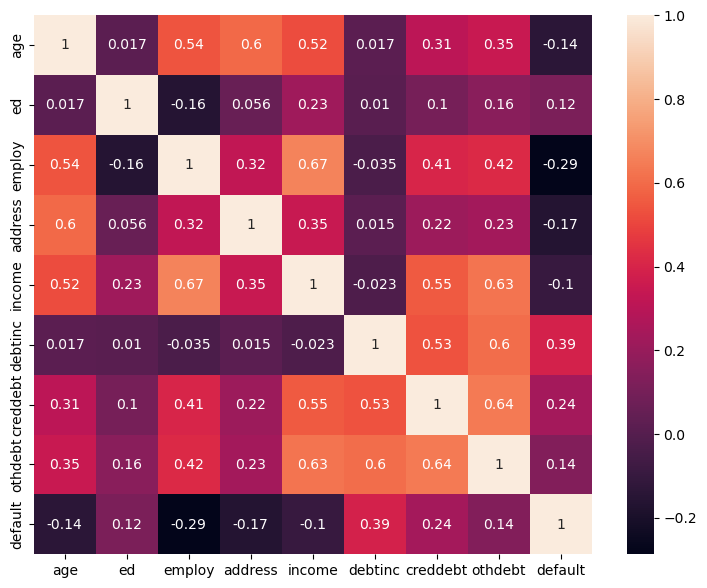

In [33]:
plt.figure( figsize = (9,7) )
sns.heatmap( existing_cust.corr(), annot = True )
plt.show()

In [34]:
banks_corelations = existing_cust.corr().to_excel(r"C:\Users\Hp\OneDrive\Desktop\python class files\bank_loans.xlsx")

##### Model Building

In [36]:
## train,test split


train , test = train_test_split( existing_cust , train_size = 0.7 , test_size = 0.3 , random_state = 1 )

In [37]:
train.head()

age  ed  employ  address  income  debtinc  creddebt    othdebt  default
286  29.0   1   11.00      7.0    32.0      6.0  0.927360   0.992640      0.0
146  28.0   4    1.00      3.0    26.0     12.4  0.377208   2.846792      0.0
214  34.0   1   16.00      3.0    75.0     10.4  3.954600   3.845400      0.0
528  51.0   2   27.01     14.0   190.3      7.8  4.272840  15.149160      0.0
165  40.0   2   13.00     11.0   102.0     18.9  6.226794  13.051206      1.0

In [38]:
test.head()

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
681  21.0   1     4.0      0.0    15.0      9.7  0.200984  1.157016      1.0
626  31.0   1    11.0     12.0    47.0     10.9  2.863757  2.259243      0.0
329  30.0   1     8.0      6.0    23.0     12.0  0.761760  1.998240      0.0
620  25.0   1     1.0      1.0    19.0      6.9  0.190095  1.120905      0.0
399  23.0   1     2.0      2.0    16.0      9.6  0.804864  0.731136      1.0

In [39]:
## Define the modal formula , define & fit the model
## we need features before the formuka

features = existing_cust.columns.difference(['default'])
features

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [40]:
# define the formula

formula_m0 = 'default ~ ' + ' + '.join(features)
formula_m0

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [41]:
# define & fit the model

lm0 = smf.logit( formula = formula_m0 , data = train ).fit()

Optimization terminated successfully.
         Current function value: 0.398129
         Iterations 8


In [42]:
## modal summaries

print( lm0.summary2() )

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.302     
Date:               2025-06-19 11:48 AIC:              407.3698  
No. Observations:   489              BIC:              445.1010  
Df Model:           8                Log-Likelihood:   -194.68   
Df Residuals:       480              LL-Null:          -279.03   
Converged:          1.0000           LLR p-value:      2.4368e-32
No. Iterations:     8.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.6798    0.7856  -2.1383  0.0325  -3.2194  -0.1401
address       -0.1068    0.0275  -3.8879  0.0001  -0.1607  -0.0530
age            0.0421    0.0206   2.0509  0.0403   0.0019   0.0824
creddebt       0.7383    0.153

* Pseudo R-squared: must be less than 2% we need to reduce our features
* the p val must be less than 0.1, but many vars surpases it
* Hence, feature selection is the imp step

#### Variable Reductions

    variable reductions in the logistic regression is based upon Somar's D Score
    Bi - variate anaysis is used to check the relationship b/w the x vars with the y vars
    the cutoff which is less than 0.2 or 20 % is regraded as the insignificant variables.

In [45]:
features

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

##### to calculate the Somar's D values following steps need to be taken care of

* prepare an empty dataframe
* for loop (for i in features )
* define formula
* define & fit the modal
* modal predictions (.predict)
* acuuracies (roc_auc_score) (concordance)
* somar'd d value
* temp_dataframe . t
* conaction in the empy df pd.conacat ( axis = 0 )
* df.columns = ['column names']


In [47]:
somars_d = pd.DataFrame()

for i in features:

    modal = smf.logit(' default ~ ' + i , train).fit()

    pred_mod_probab = modal.predict(existing_cust)

    mod_accuracy = roc_auc_score( existing_cust.default , pred_mod_probab )

    sormar_score = 2 * mod_accuracy - 1

    temp_df = pd.DataFrame( [ i , mod_accuracy , sormar_score ] ).T

    somars_d = pd.concat([ somars_d , temp_df ] , axis = 0, ignore_index = True )

somars_d.columns = ['features' , 'Concordance' , 'Somarsd_Score' ]
somars_d

Optimization terminated successfully.
         Current function value: 0.559401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560873
         Iterations 5


features Concordance Somarsd_Score
0   address    0.611192      0.222384
1       age    0.603165      0.206329
2  creddebt    0.636189      0.272378
3   debtinc    0.735253      0.470506
4        ed    0.574151      0.148302
5    employ    0.704569      0.409138
6    income    0.600136      0.200273
7   othdebt    0.586903      0.173806

##### feature Selection

* somar's d value must be greater than 0.2 | 20%

In [49]:
features = list( somars_d.loc[ somars_d.Somarsd_Score >= 0.2 , 'features' ] )
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

##### Multi-Colinearity Check

    - dmatrices
    - vif score

In [51]:
formula = 'default ~ ' + ' + '.join(features)
formula

'default ~ address + age + creddebt + debtinc + employ + income'

In [52]:
y , X = dmatrices( formula_like = formula , data = existing_cust , return_type = 'dataframe' )

In [53]:
X # correlations of the x var with the y var

Intercept  address   age  creddebt  debtinc  employ  income
0          1.0     12.0  41.0  9.891428      9.3    17.0   176.0
1          1.0      6.0  27.0  1.362202     17.3    10.0    31.0
2          1.0     14.0  40.0  0.856075      5.5    15.0    55.0
3          1.0     14.0  41.0  2.658720      2.9    15.0   120.0
4          1.0      0.0  24.0  1.787436     17.3     2.0    28.0
..         ...      ...   ...       ...      ...     ...     ...
695        1.0     15.0  36.0  0.262062      4.6     6.0    27.0
696        1.0      4.0  29.0  0.369495     11.5     6.0    21.0
697        1.0      3.0  33.0  0.491264      7.6    15.0    32.0
698        1.0     22.0  45.0  2.302608      8.4    19.0    77.0
699        1.0     14.0  37.0  2.994684     14.7    12.0    44.0

[700 rows x 7 columns]

In [54]:
## vif

vif = pd.DataFrame()

vif['Features'] = X.columns

vif['VIF_Score']  = [ variance_inflation_factor( X.values , i ) for i in range( X.shape[1] ) ]

vif

Features  VIF_Score
0  Intercept  28.286222
1    address   1.559236
2        age   2.036933
3   creddebt   2.564921
4    debtinc   1.778339
5     employ   1.997947
6     income   2.601717

* no vif score is greater than 5, hence all are the significant vars

##### Build the actual model with all the significant variable.

In [57]:
## define & fit the model

formula_m1 = ' default ~ ' + ' + '.join(features)
formula_m1

' default ~ address + age + creddebt + debtinc + employ + income'

In [58]:
m1 = smf.logit( formula = formula_m1 , data = train).fit()

Optimization terminated successfully.
         Current function value: 0.398998
         Iterations 7


In [59]:
# modal summaries

print( m1.summary2() )

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.301     
Date:               2025-06-19 11:48 AIC:              404.2203  
No. Observations:   489              BIC:              433.5668  
Df Model:           6                Log-Likelihood:   -195.11   
Df Residuals:       482              LL-Null:          -279.03   
Converged:          1.0000           LLR p-value:      1.2972e-33
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.9354    0.6378  -3.0346  0.0024  -3.1854  -0.6854
address       -0.1068    0.0275  -3.8811  0.0001  -0.1607  -0.0529
age            0.0400    0.0204   1.9605  0.0499   0.0000   0.0800
creddebt       0.6866    0.137

* **Pseudo R-squared:** is in the range of 0.4-0.6 which is a decent value
* **the p values** > than 0.1 hence, we need to remove them manually

In [61]:
formula_m2 = ' default ~ address +  creddebt + debtinc + employ '

In [62]:
m2 = smf.logit( formula_m2, train).fit()

Optimization terminated successfully.
         Current function value: 0.403114
         Iterations 7


In [63]:
print( m2.summary2() )

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.294     
Date:               2025-06-19 11:48 AIC:              404.2456  
No. Observations:   489              BIC:              425.2074  
Df Model:           4                Log-Likelihood:   -197.12   
Df Residuals:       484              LL-Null:          -279.03   
Converged:          1.0000           LLR p-value:      2.2319e-34
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.0376    0.3030  -3.4244  0.0006  -1.6315  -0.4437
address       -0.0810    0.0230  -3.5183  0.0004  -0.1262  -0.0359
creddebt       0.6296    0.1064   5.9166  0.0000   0.4210   0.8382
debtinc        0.0887    0.022

* **Pseudo R-squared** value reduces a little
* while working with the bankind data we have to go with 95% CI | 0.05
* the col income has the > ci
* also, income has been included in the debtinc col
* hence, remove income
* lesser the pvalue is the more significant variables
* now, the modal is good to go

##### Model Predictions

    predict the values of y of both train & test

In [66]:
train_predict = m2.predict(train)
test_predict = m2.predict(test)

In [67]:
train_predict.head()

286    0.053533
146    0.460122
214    0.208246
528    0.009536
165    0.700782
dtype: float64

In [68]:
test_predict.head()

681    0.285495
626    0.164695
329    0.152742
620    0.353536
399    0.431760
dtype: float64

In [69]:
train.head()

age  ed  employ  address  income  debtinc  creddebt    othdebt  default
286  29.0   1   11.00      7.0    32.0      6.0  0.927360   0.992640      0.0
146  28.0   4    1.00      3.0    26.0     12.4  0.377208   2.846792      0.0
214  34.0   1   16.00      3.0    75.0     10.4  3.954600   3.845400      0.0
528  51.0   2   27.01     14.0   190.3      7.8  4.272840  15.149160      0.0
165  40.0   2   13.00     11.0   102.0     18.9  6.226794  13.051206      1.0

In [70]:
test.head()

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
681  21.0   1     4.0      0.0    15.0      9.7  0.200984  1.157016      1.0
626  31.0   1    11.0     12.0    47.0     10.9  2.863757  2.259243      0.0
329  30.0   1     8.0      6.0    23.0     12.0  0.761760  1.998240      0.0
620  25.0   1     1.0      1.0    19.0      6.9  0.190095  1.120905      0.0
399  23.0   1     2.0      2.0    16.0      9.6  0.804864  0.731136      1.0

##### Model Scoring

    auc_roc score

In [72]:
train_roc = roc_auc_score( train.default , train_predict )
test_roc = roc_auc_score( test.default , test_predict )

print( 'The ROC score of the Train Data is ', train_roc) # training data is 84% accurate
print( 'The ROC score of the Test Data is ', test_roc) # testing data is 85% accurate

The ROC score of the Train Data is  0.8485723031177577
The ROC score of the Test Data is  0.8576998050682261


##### Combining y_act to the y_predicted probablities

In [74]:
## to divide the values in the form of 1s and 0s

train_act_probab = pd.DataFrame( train_predict )

train_df = pd.concat( [ train.default , train_act_probab ] , axis = 1 ).reset_index(drop = True )
train_df.columns = ['Actual' , 'Predict_Probab' ]
train_df

Actual  Predict_Probab
0       0.0        0.053533
1       0.0        0.460122
2       0.0        0.208246
3       0.0        0.009536
4       1.0        0.700782
..      ...             ...
484     0.0        0.020755
485     0.0        0.005933
486     1.0        0.467250
487     0.0        0.012705
488     0.0        0.161592

[489 rows x 2 columns]

In [75]:
test_act_probab = pd.DataFrame( test_predict )

test_df = pd.concat( [ test.default , test_act_probab ] , axis = 1 ).reset_index(drop = True )
test_df.columns = ['Actual' , 'Predict_Probab' ]
test_df

Actual  Predict_Probab
0       1.0        0.285495
1       0.0        0.164695
2       0.0        0.152742
3       0.0        0.353536
4       1.0        0.431760
..      ...             ...
205     0.0        0.445138
206     0.0        0.079158
207     0.0        0.068545
208     0.0        0.317755
209     0.0        0.004749

[210 rows x 2 columns]

##### Best Cut off to find out the y_pred from the y_pred_probab

    best cutoff could be find out by 3 ways:-

        1. Acuracy - misleading sometimes
        2. TPR( Sensitivity)
        3. Sensitivity + specificity:- used most of the times.

##### steps to follow

* create an empty dataframe
* for loop
* np.where probab>= i
* confusion matrix
* tp/tn/fp/fn
* rowstotal axis = 1
* fomulas:- tpr/fpr/specofictu/snest+speci/axuuracy
* saving the results in temp-df
* concationation in the above df
* cols name
* print the df

In [78]:
best_cutoff = pd.DataFrame()

for i in np.arange( 0.0 , 1.01 , 0.01 ): # for loop i will iteration over 0,0.1 and it's goes on

    y_predicted = pd.Series( np.where( train_df.Predict_Probab >= i , 1 , 0 ) ) # to check the probabs

    cm = confusion_matrix( train_df.Actual , y_predicted )[ : : -1 , : : -1 ]# revesrse the order to make it as 0 & 1 repectively

    tp = cm[ 0,0 ] # index numbs of the cols as 1 & 0
    fp = cm[ 1,0 ]
    tn = cm[ 1,1 ]
    fn = cm[ 0,1 ]

    total = cm.sum(axis = 1 ) # rows sum to be used in formula as actuals+ives and actual - ives

    # calculate the formulas
    tpr = (tp) / total[0]
    fpr = (fp) / total[1]
    specificity = 1 - fpr
    accuracy = (tp + tn ) / cm.sum()
    spec_sens = tpr + specificity

    tempo_df = pd.DataFrame( [i , tp , tn , fn, fp , tpr , fpr, specificity , accuracy , spec_sens ] ).T

    best_cutoff = pd.concat( [best_cutoff , tempo_df ] ,  axis = 0 )

best_cutoff.columns = [ 'probab' , 'TP' , "TN" , 'FP' , 'FN' , 'TPR' , 'FPR' , 'Specificity' , 'Accuracy' , 'Speci_Sens' ]
best_cutoff

probab     TP     TN     FP     FN       TPR       FPR  Specificity  \
0     0.00  126.0    0.0    0.0  363.0  1.000000  1.000000     0.000000   
0     0.01  126.0   41.0    0.0  322.0  1.000000  0.887052     0.112948   
0     0.02  126.0   66.0    0.0  297.0  1.000000  0.818182     0.181818   
0     0.03  125.0   89.0    1.0  274.0  0.992063  0.754821     0.245179   
0     0.04  124.0  104.0    2.0  259.0  0.984127  0.713499     0.286501   
..     ...    ...    ...    ...    ...       ...       ...          ...   
0     0.96    2.0  363.0  124.0    0.0  0.015873  0.000000     1.000000   
0     0.97    0.0  363.0  126.0    0.0  0.000000  0.000000     1.000000   
0     0.98    0.0  363.0  126.0    0.0  0.000000  0.000000     1.000000   
0     0.99    0.0  363.0  126.0    0.0  0.000000  0.000000     1.000000   
0     1.00    0.0  363.0  126.0    0.0  0.000000  0.000000     1.000000   

    Accuracy  Speci_Sens  
0   0.257669    1.000000  
0   0.341513    1.112948  
0   0.392638    1.181818  
0   0.437628    1.237243  
0   0.466258    1.270628  
..       ...         ...  
0   0.746421    1.015873  
0   0.742331    1.000000  
0   0.742331    1.000000  
0   0.742331    1.000000  
0   0.742331    1.000000  

[101 rows x 10 columns]

* **the max value of the col Speci_Sens is calculted and then it will get compared with the probab col to get the best cutoff**
* choose the max value of this col and then it get's compared with this col itself.

In [80]:
cut_off = best_cutoff.loc[ best_cutoff.Speci_Sens == best_cutoff.Speci_Sens.max() , 'probab' ]
cut_off = cut_off.iloc[0]
cut_off

0.28

* **The chosen bets cutoff is 0.28 based on highest specificity +  sensitivity.**

##### Now the y_predictions will happen upon this cut-off of 0.28

In [83]:
train_df['y_predicted'] = pd.Series( np.where( train_df.Predict_Probab >= cut_off , 1 , 0 ) )

In [84]:
test_df['y_predicted'] = pd.Series( np.where( test_df.Predict_Probab >= cut_off , 1 , 0 ) )

In [85]:
train_df.head()

Actual  Predict_Probab  y_predicted
0     0.0        0.053533            0
1     0.0        0.460122            1
2     0.0        0.208246            0
3     0.0        0.009536            0
4     1.0        0.700782            1

In [86]:
test_df.head()

Actual  Predict_Probab  y_predicted
0     1.0        0.285495            1
1     0.0        0.164695            0
2     0.0        0.152742            0
3     0.0        0.353536            1
4     1.0        0.431760            1

##### Modal Accuracies

    accuracy score of the modal 

In [88]:
print( 'the model accuracy of the Train Data is :' , accuracy_score( train_df.Actual , train_df.y_predicted ) )

print( 'the model accuracy of the Test Data is :' , accuracy_score( test_df.Actual , test_df.y_predicted ) )
      

the model accuracy of the Train Data is : 0.7893660531697342
the model accuracy of the Test Data is : 0.7666666666666667


In [89]:
print(classification_report(train_df.Actual, train_df.y_predicted))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       363
         1.0       0.57      0.78      0.66       126

    accuracy                           0.79       489
   macro avg       0.74      0.79      0.75       489
weighted avg       0.82      0.79      0.80       489



* **Precision:** %age of correct +ve predictions relative to total +ve predictions.
* **Recall:** %age of correct +ve predictions relative to total actual positives
* **F1 Score:** mean of precision & recall. The value must be  close to 1, hence better the model!
            
            F1 score = 2* (Precision*Recall)/ (Precison + Recall)

#### Model Validations

    deciles analysis:- it is made on the basis of probab.

* in Logistic Regression the table 1 of deciles is to be created by using the pd.qcut
* the table 2 which is the crosstab it includes actual , prob , min and max of probab
* sum and count of actual.

In [92]:
train_df['Deciles'] = pd.qcut( train_df.Predict_Probab , 10 , labels = False )
test_df['Deciles'] = pd.qcut( test_df.Predict_Probab , 10 , labels = False )

In [93]:
train_df.head()

Actual  Predict_Probab  y_predicted  Deciles
0     0.0        0.053533            0        2
1     0.0        0.460122            1        7
2     0.0        0.208246            0        5
3     0.0        0.009536            0        0
4     1.0        0.700782            1        9

In [94]:
test_df.head()

Actual  Predict_Probab  y_predicted  Deciles
0     1.0        0.285495            1        6
1     0.0        0.164695            0        4
2     0.0        0.152742            0        4
3     0.0        0.353536            1        7
4     1.0        0.431760            1        7

In [95]:
train_deciles = train_df.groupby('Deciles')[ ['Actual' , 'Predict_Probab' ] ].agg({ 'Actual' : [sum , 'count'] , 'Predict_Probab' : 
                                                                  [ np.max , np.min ]}).reset_index().sort_values(by = 'Deciles' , 
                                                                                                                 ascending = False)
train_deciles

C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\1722817862.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  train_deciles = train_df.groupby('Deciles')[ ['Actual' , 'Predict_Probab' ] ].agg({ 'Actual' : [sum , 'count'] , 'Predict_Probab' :
C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\1722817862.py:1: FutureWarning: The provided callable <function max at 0x0000022A644240E0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_deciles = train_df.groupby('Deciles')[ ['Actual' , 'Predict_Probab' ] ].agg({ 'Actual' : [sum , 'count'] , 'Predict_Probab' :
C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\1722817862.py:1: FutureWarning: The provided callable <function min at 0x0000022A6442

Deciles Actual       Predict_Probab          
             sum count            max       min
9       9   39.0    49       0.967836  0.676023
8       8   26.0    49       0.675160  0.467250
7       7   21.0    49       0.466431  0.337468
6       6   14.0    49       0.329127  0.239995
5       5    8.0    48       0.239815  0.190572
4       4    9.0    49       0.188976  0.128023
3       3    4.0    49       0.127036  0.067027
2       2    3.0    49       0.065942  0.036831
1       1    2.0    49       0.036818  0.012340
0       0    0.0    49       0.012276  0.000864

In [96]:
test_deciles = test_df.groupby('Deciles')[ ['Actual' , 'Predict_Probab' ] ].agg({ 'Actual' : [sum , 'count'] , 'Predict_Probab' : 
                                                                  [ np.max , np.min ]}).reset_index().sort_values(by = 'Deciles' , 
                                                                                                                 ascending = False)
test_deciles

C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\2998219637.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  test_deciles = test_df.groupby('Deciles')[ ['Actual' , 'Predict_Probab' ] ].agg({ 'Actual' : [sum , 'count'] , 'Predict_Probab' :
C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\2998219637.py:1: FutureWarning: The provided callable <function max at 0x0000022A644240E0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  test_deciles = test_df.groupby('Deciles')[ ['Actual' , 'Predict_Probab' ] ].agg({ 'Actual' : [sum , 'count'] , 'Predict_Probab' :
C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\2998219637.py:1: FutureWarning: The provided callable <function min at 0x0000022A64424220

Deciles Actual       Predict_Probab          
             sum count            max       min
9       9   18.0    21       0.985679  0.643839
8       8   13.0    21       0.612833  0.470155
7       7    6.0    21       0.459267  0.353536
6       6    9.0    21       0.347456  0.254467
5       5    5.0    21       0.250986  0.169139
4       4    1.0    21       0.168526  0.105759
3       3    2.0    21       0.103146  0.074453
2       2    3.0    21       0.074050  0.042419
1       1    0.0    21       0.042086  0.015149
0       0    0.0    21       0.013653  0.001642

* **In Decile Analysis:**
    
        i. The top 2 deciles: High risk customers---> will reject the applications
        ii. 3rd, 4th, 5th decile: medium risk customer----> will accept applications with proper scrutiny
        iii. 6th decile onwards: Low risk customers---> accept the applications

#### Implementation of this modal upon the new_cust

    now, we hve to implement the modal which we have prepared to calculate the risk upon the new cust

    

In [99]:
new_cust.head()

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
700   36   1      16       13      32     10.9  0.544128  2.943872      NaN
701   50   1       6       27      21     12.9  1.316574  1.392426      NaN
702   40   1       9        9      33     17.0  4.880700  0.729300      NaN
703   31   1       5        7      23      2.0  0.046000  0.414000      NaN
704   29   1       4        0      24      7.8  0.866736  1.005264      NaN

In [100]:
new_cust.loc[ :: , 'Probab' ] = m2.predict( new_cust )

C:\Users\Hp\AppData\Local\Temp\ipykernel_7892\2851953544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_cust.loc[ :: , 'Probab' ] = m2.predict( new_cust )


In [101]:
new_cust

age  ed  employ  address  income  debtinc  creddebt   othdebt  default  \
700   36   1      16       13      32     10.9  0.544128  2.943872      NaN   
701   50   1       6       27      21     12.9  1.316574  1.392426      NaN   
702   40   1       9        9      33     17.0  4.880700  0.729300      NaN   
703   31   1       5        7      23      2.0  0.046000  0.414000      NaN   
704   29   1       4        0      24      7.8  0.866736  1.005264      NaN   
..   ...  ..     ...      ...     ...      ...       ...       ...      ...   
845   34   1      12       15      32      2.7  0.239328  0.624672      NaN   
846   32   2      12       11     116      5.7  4.026708  2.585292      NaN   
847   48   1      13       11      38     10.8  0.722304  3.381696      NaN   
848   35   2       1       11      24      7.8  0.417456  1.454544      NaN   
849   37   1      20       13      41     12.9  0.899130  4.389870      NaN   

       Probab  
700  0.014081  
701  0.072272  
702  0.703463  
703  0.077132  
704  0.339222  
..        ...  
845  0.011393  
846  0.184147  
847  0.034448  
848  0.233110  
849  0.008884  

[150 rows x 10 columns]

* now this col of probab the best cut off of 0.28 will help us to fill the default col

In [103]:
new_cust.loc[ : , 'default' ] = new_cust['Probab'].apply( lambda x : 1 if x > cut_off else 0  )

In [104]:
new_cust

age  ed  employ  address  income  debtinc  creddebt   othdebt  default  \
700   36   1      16       13      32     10.9  0.544128  2.943872      0.0   
701   50   1       6       27      21     12.9  1.316574  1.392426      0.0   
702   40   1       9        9      33     17.0  4.880700  0.729300      1.0   
703   31   1       5        7      23      2.0  0.046000  0.414000      0.0   
704   29   1       4        0      24      7.8  0.866736  1.005264      1.0   
..   ...  ..     ...      ...     ...      ...       ...       ...      ...   
845   34   1      12       15      32      2.7  0.239328  0.624672      0.0   
846   32   2      12       11     116      5.7  4.026708  2.585292      0.0   
847   48   1      13       11      38     10.8  0.722304  3.381696      0.0   
848   35   2       1       11      24      7.8  0.417456  1.454544      0.0   
849   37   1      20       13      41     12.9  0.899130  4.389870      0.0   

       Probab  
700  0.014081  
701  0.072272  
702  0.703463  
703  0.077132  
704  0.339222  
..        ...  
845  0.011393  
846  0.184147  
847  0.034448  
848  0.233110  
849  0.008884  

[150 rows x 10 columns]

In [105]:
new_cust.default.value_counts()

default
0.0    98
1.0    52
Name: count, dtype: int64

* hence, 98 applications is accepted & 52 applications will be rejected by the bnk.

##### Selecting cut-off from the visualisations

    2 seperate charts will be prepared for 0 nd 1
    their intersection will be the best cutoff

<Axes: xlabel='Predict_Probab', ylabel='Count'>

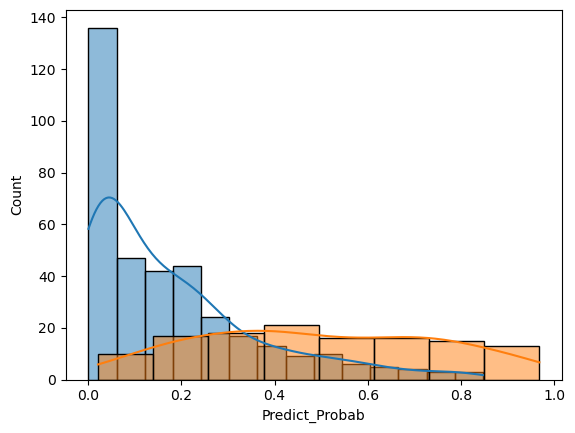

In [179]:
sns.histplot( train_df.loc[ train_df.Actual == 0 , 'Predict_Probab' ] , kde = True)
sns.histplot( train_df.loc[ train_df.Actual == 1 , 'Predict_Probab' ] , kde = True )
